<a href="https://colab.research.google.com/github/aguzel/computational_imaging/blob/main/CompLightPercep_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from PIL import Image
import numpy as np_cpu
import matplotlib.pyplot as plt
import matplotlib.colors

import torch
import torch.optim as optim

from torchvision import transforms


%matplotlib inline

In [2]:
def load_image(fn):
    """
    Definition to load an image from a given location as a Numpy array.
    Parameters
    ----------
    fn           : str
                   Filename.
    Returns
    ----------
    image        :  ndarray
                    Image loaded as a Numpy array.
    """
    image = Image.open(fn)
    image = np_cpu.array(image)
    image = torch.from_numpy(image)
    return image

In [3]:
def rgb_2_ycrcb(image):
    """
    Converts an image from RGB colourspace to YCrCb colourspace.
    Parameters
    ----------
    image   : torch.tensor
                Input image. Should be an RGB floating-point image with values in the range [0, 1]
                Should be in NCHW format.
    Returns
    -------
    ycrcb   : torch.tensor
                Image converted to YCrCb colourspace.
    """
    ycrcb = torch.zeros(image.size()).to(image.device)
    ycrcb[:, 0, :, :] = 0.299 * image[:, 0, :, :] + 0.587 * \
        image[:, 1, :, :] + 0.114 * image[:, 2, :, :]
    ycrcb[:, 1, :, :] = 0.5 + 0.713 * (image[:, 0, :, :] - ycrcb[:, 0, :, :])
    ycrcb[:, 2, :, :] = 0.5 + 0.564 * (image[:, 2, :, :] - ycrcb[:, 0, :, :])
    return ycrcb

In [4]:
# Im = Image.open('/content/image2.png')
# Im

In [5]:
tensor_image_1 = load_image('/content/parrot.png')
tensor_image_1 = tensor_image_1/255.0
tensor_image_2 = load_image('/content/parrot.png')
tensor_image_2 = tensor_image_2/255.0

In [6]:
nchw_image_1 = torch.swapaxes(tensor_image_1,0,2)
nchw_image_2 = torch.swapaxes(tensor_image_2,0,2)
print(nchw_image_1.unsqueeze(0).shape) # Add batch dimension for NCHW, prints "torch.Size([1, 3, 2, 2])"
print(nchw_image_2.unsqueeze(0).shape) # Add batch dimension for NCHW, prints "torch.Size([1, 3, 2, 2])"
nchw_image_1 = nchw_image_1.unsqueeze(0)
nchw_image_2 = nchw_image_2.unsqueeze(0)

torch.Size([1, 3, 1001, 1001])
torch.Size([1, 3, 1001, 1001])


In [7]:
ycrcb_image_1 = rgb_2_ycrcb(nchw_image_1)
ycrcb_image_2 = rgb_2_ycrcb(nchw_image_2)

In [8]:
def ycrcb_2_rgb(image):
    """
    Converts an image from YCrCb colourspace to RGB colourspace.
    Parameters
    ----------
    image   : torch.tensor
                Input image. Should be a YCrCb floating-point image with values in the range [0, 1]
                Should be in NCHW format.
    Returns
    -------
    rgb     : torch.tensor
                Image converted to RGB colourspace.
    """
    rgb = torch.zeros(image.size(), device=image.device)
    rgb[:, 0, :, :] = image[:, 0, :, :] + 1.403 * (image[:, 1, :, :] - 0.5)
    rgb[:, 1, :, :] = image[:, 0, :, :] - 0.714 * \
        (image[:, 1, :, :] - 0.5) - 0.344 * (image[:, 2, :, :] - 0.5)
    rgb[:, 2, :, :] = image[:, 0, :, :] + 1.773 * (image[:, 2, :, :] - 0.5)
    return rgb

In [9]:
rgb_1 = ycrcb_2_rgb(ycrcb_image_1)
rgb_1 = rgb_1.squeeze(0)
rgb_1 = rgb_1.swapaxes(0,2)
rgb_1.size()


torch.Size([1001, 1001, 3])

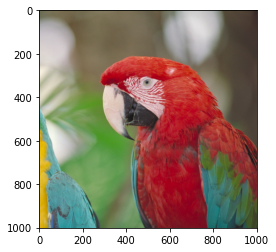

In [10]:
image_np_array_1 = plt.imread('/content/parrot.png')
np_arr = rgb_1.cpu().detach().numpy()
plt.imshow(np_arr)

In [11]:
np_arr

array([[[0.41961166, 0.4195944 , 0.32157108],
        [0.4156891 , 0.41959384, 0.32157105],
        [0.41961068, 0.4235154 , 0.32549262],
        ...,
        [0.21177462, 0.17255253, 0.15686348],
        [0.21177462, 0.17255253, 0.15686348],
        [0.20393059, 0.1686304 , 0.15294185]],

       [[0.42745388, 0.4313585 , 0.33333573],
        [0.42745388, 0.4313585 , 0.33333573],
        [0.4156891 , 0.41959384, 0.32157105],
        ...,
        [0.20393059, 0.1686304 , 0.15294185],
        [0.21177462, 0.17255253, 0.15686348],
        [0.20785306, 0.16863099, 0.15294188]],

       [[0.43137553, 0.43527958, 0.33333585],
        [0.4196105 , 0.42351598, 0.3294141 ],
        [0.4156891 , 0.41959384, 0.32157105],
        ...,
        [0.20393133, 0.16470996, 0.1529418 ],
        [0.20393059, 0.1686304 , 0.15294185],
        [0.20393133, 0.16470996, 0.1529418 ]],

       ...,

       [[0.86672485, 0.7097524 , 0.16864216],
        [0.8628064 , 0.69406676, 0.14511305],
        [0.85888594, 0

In [12]:
ycrcb_image_2.size()

torch.Size([1, 3, 1001, 1001])

In [13]:
loss_fn = torch.nn.MSELoss()

x = torch.autograd.Variable(torch.zeros(1,3,1001,1001), requires_grad=True)
input = torch.zeros(1,3,1001,1001,requires_grad=True)
target = ycrcb_image_1
print(target)

tensor([[[[0.4084, 0.4190, 0.4225,  ..., 0.6950, 0.6936, 0.6945],
          [0.4073, 0.4190, 0.4116,  ..., 0.6819, 0.6819, 0.6780],
          [0.4112, 0.4073, 0.4073,  ..., 0.6749, 0.6757, 0.6767],
          ...,
          [0.1825, 0.1774, 0.1751,  ..., 0.2428, 0.2428, 0.2451],
          [0.1825, 0.1825, 0.1774,  ..., 0.2428, 0.2394, 0.2405],
          [0.1774, 0.1786, 0.1751,  ..., 0.2285, 0.2262, 0.2297]],

         [[0.5080, 0.5060, 0.5063,  ..., 0.6224, 0.6234, 0.6228],
          [0.5060, 0.5060, 0.5057,  ..., 0.6289, 0.6290, 0.6290],
          [0.5060, 0.5060, 0.5060,  ..., 0.6311, 0.6305, 0.6299],
          ...,
          [0.5209, 0.5189, 0.5206,  ..., 0.4834, 0.4834, 0.4818],
          [0.5209, 0.5209, 0.5189,  ..., 0.4834, 0.4831, 0.4851],
          [0.5189, 0.5209, 0.5206,  ..., 0.4825, 0.4841, 0.4844]],

         [[0.4510, 0.4517, 0.4497,  ..., 0.2031, 0.2083, 0.2123],
          [0.4517, 0.4517, 0.4536,  ..., 0.1972, 0.2083, 0.2083],
          [0.4517, 0.4517, 0.4517,  ..., 0

In [14]:
optimizer = optim.Adam(params=[{'params': [x]}], lr = 0.00001)
input = torch.ones_like(target)
niter = 100
for _ in range(0, niter):
 optimizer.zero_grad()
 output = torch.matmul(input,x)
 loss = loss_fn(output, target)
#  input = output
 loss.backward()
 print(loss)
 optimizer.step()



tensor(0.2516, grad_fn=<MseLossBackward0>)
tensor(0.2420, grad_fn=<MseLossBackward0>)
tensor(0.2327, grad_fn=<MseLossBackward0>)
tensor(0.2235, grad_fn=<MseLossBackward0>)
tensor(0.2146, grad_fn=<MseLossBackward0>)
tensor(0.2059, grad_fn=<MseLossBackward0>)
tensor(0.1974, grad_fn=<MseLossBackward0>)
tensor(0.1891, grad_fn=<MseLossBackward0>)
tensor(0.1811, grad_fn=<MseLossBackward0>)
tensor(0.1733, grad_fn=<MseLossBackward0>)
tensor(0.1657, grad_fn=<MseLossBackward0>)
tensor(0.1583, grad_fn=<MseLossBackward0>)
tensor(0.1511, grad_fn=<MseLossBackward0>)
tensor(0.1442, grad_fn=<MseLossBackward0>)
tensor(0.1375, grad_fn=<MseLossBackward0>)
tensor(0.1311, grad_fn=<MseLossBackward0>)
tensor(0.1248, grad_fn=<MseLossBackward0>)
tensor(0.1188, grad_fn=<MseLossBackward0>)
tensor(0.1131, grad_fn=<MseLossBackward0>)
tensor(0.1075, grad_fn=<MseLossBackward0>)
tensor(0.1022, grad_fn=<MseLossBackward0>)
tensor(0.0970, grad_fn=<MseLossBackward0>)
tensor(0.0921, grad_fn=<MseLossBackward0>)
tensor(0.08

In [15]:
image_result = torch.matmul(input,x)
rgb_out = ycrcb_2_rgb(image_result)


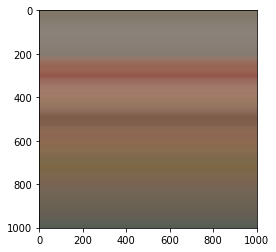

In [16]:
image_out = rgb_out.squeeze(0)
image_out = image_out.swapaxes(0,2)
image_out.size()

np_arr_2 = image_out.cpu().detach().numpy()
plt.imshow(np_arr_2)

In [17]:
np_arr-np_arr_2

array([[[-0.07184222, -0.04385188, -0.0795674 ],
        [-0.07576478, -0.04385245, -0.07956743],
        [-0.07184321, -0.03993088, -0.07564586],
        ...,
        [-0.27967927, -0.29089376, -0.244275  ],
        [-0.27967927, -0.29089376, -0.244275  ],
        [-0.2875233 , -0.2948159 , -0.24819663]],

       [[-0.06500915, -0.03208902, -0.06849086],
        [-0.06500915, -0.03208902, -0.06849086],
        [-0.07677391, -0.04385367, -0.08025554],
        ...,
        [-0.28853244, -0.2948171 , -0.24888474],
        [-0.2806884 , -0.290895  , -0.24496311],
        [-0.28460997, -0.29481652, -0.24888471]],

       [[-0.06264612, -0.0286139 , -0.06951824],
        [-0.07441115, -0.0403775 , -0.07343999],
        [-0.07833254, -0.04429963, -0.08128303],
        ...,
        [-0.29009032, -0.29918352, -0.24991229],
        [-0.29009107, -0.29526305, -0.24991223],
        [-0.29009032, -0.29918352, -0.24991229]],

       ...,

       [[ 0.5318215 ,  0.3496655 , -0.15079355],
        [ 0

In [18]:
np_arr - 

SyntaxError: ignored